<h1>Ipython Notebook for Dissertation</h1> 
<h1>MSc Data Science</h1>
<h2>Student: Sergio Garcia de alba</h2>
<h2>Advisor: Simon D. Rogers, PhD</h2>
<h2><i>University of Glasgow</i></h2>
<img src="http://www.gla.ac.uk/media/media_434161_en.jpg" align="left"></img>


<b>Objectives of this notebook</b>
<ul>
  <li>Download stock quotes and make predictions after learning a hmm model for the company/market</li>
  <li>Check if Viterbi always returns as the last state the most likely current state</li>
  <li>Make a signficant number of simulations with the known current state and average</li>
  <li>Make a significant number of simulations with a random starting state and average</li>
  <li>Compare the averages of random starting state and known state one year out</li>
  <li>Repeat the experiment with fewer hidden states</li>
  <li>Repeat the experiment with more states</li>
</ul>

In [28]:
%matplotlib inline

from __future__ import print_function
import datetime, time
import numpy as np
import warnings
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # For Matplotlib prior to 1.5.
    from matplotlib.finance import (
        quotes_historical_yahoo as quotes_historical_yahoo_ochl
    )

from hmmlearn.hmm import GaussianHMM

now = datetime.datetime.now()

company = "MU" # NOTE: Use SPY ticker for the S&P 500 index (e.g. the market) or a company specific ticker
num_of_states = 5 # This is the number of hidden states to use in the HMM model

quotes = quotes_historical_yahoo_ochl(
    company, datetime.date(2006, 1, 1), datetime.date(now.year, now.month, now.day)) #Here we set the time range

warnings.filterwarnings('ignore') # Get rid of some annoying divide by zero in log warnings

<i>Next step is to download the price information from the Internet</i>


In [29]:
# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]
#print (diff)
# Pack diff and volume for training.
X = np.column_stack([diff])

<b>The model to be used is a Gaussian Hidden Markov Model </b>
<p> Here we fit the stock price information and then decode using Viterbi the most likely sequence of states, in particular we are interested in the last state</p>


In [30]:
# Create HMM instance and fit
model = GaussianHMM(n_components=num_of_states, covariance_type="full", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
hidden_probs = model.predict_proba(X)


In [31]:
print ("\nMost likely state of last observation:",hidden_states[-1])
#print ("# of observations",hidden_states.size)
print ("\nProb. distr. of states for last observation: \n")
#print (hidden_probs.size,hidden_states.size)
print (np.array_str(hidden_probs[-1], precision=3, suppress_small=True))
#print ("# of hidden states",model.n_components)



Most likely state of last observation: 1

Prob. distr. of states for last observation: 

[ 0.097  0.734  0.032  0.135  0.002]


<b>
<i>NOTE: 
<p>The last state in the most likely sequence inferred by the Viterbi algorithm is not always the one with the highest probability in the posterior probability distribution for the states for the last observation. </p><p>Viterbi seems to work better than using the state with the highest posterior probability for the last observation, <u>but more tests are needed.</u></p></i>
</b>

Transition matrix: 
[[  5.32964935e-01   8.42926141e-03   4.58605803e-01   1.35331588e-60
    4.37805609e-35]
 [  3.53208630e-03   9.84147593e-01   1.15247578e-05   2.96958613e-27
    1.23087964e-02]
 [  7.34962676e-01   1.57813516e-02   2.49255973e-01   3.81082734e-52
    7.60186562e-30]
 [  1.48352438e-58   1.10014950e-02   3.64392585e-56   9.77791194e-01
    1.12073106e-02]
 [  8.57769737e-08   1.24903888e-09   3.98631844e-01   5.27388858e-01
    7.39792112e-02]]

Means and vars of each hidden state: 
hidden state # 0
mean =  [-0.018617]
var =  [ 0.02613147]

hidden state # 1
mean =  [-0.00044427]
var =  [ 0.10036961]

hidden state # 2
mean =  [ 0.05634494]
var =  [ 0.06837979]

hidden state # 3
mean =  [-0.00216389]
var =  [ 0.39456439]

hidden state # 4
mean =  [-0.47644533]
var =  [ 2.76427224]



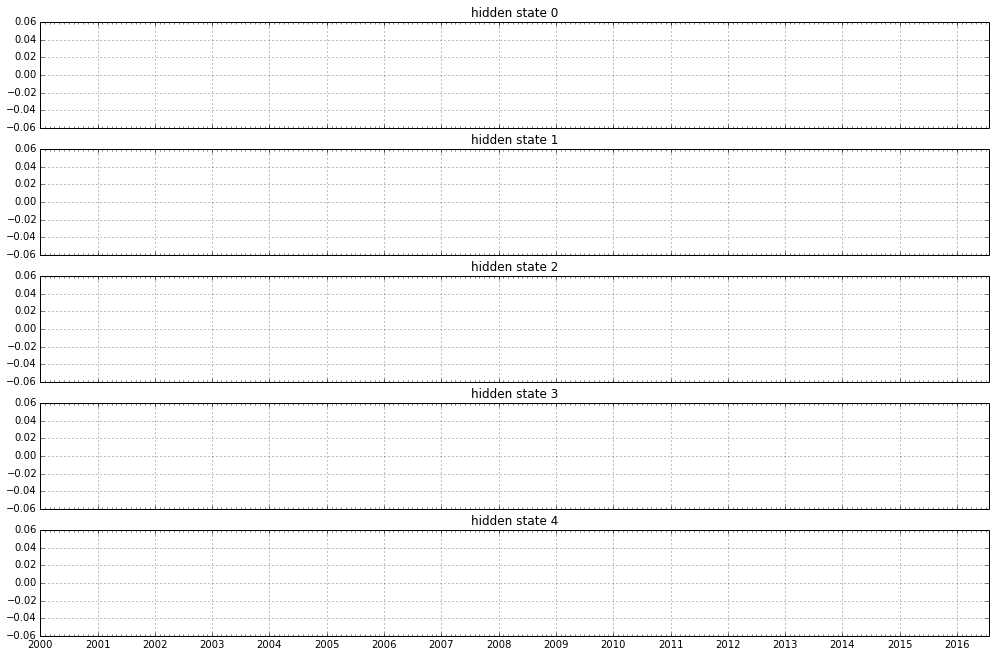

In [32]:
print("Transition matrix: ")
print(model.transmat_)

print("\nMeans and vars of each hidden state: ")
for i in range(model.n_components):
    print("hidden state # {0}".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True,figsize=(17,11))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    #print (mask)
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("hidden state {0}".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

<b>
<i>NOTE: 
<p>It is interesting that after Brexit the model gives us as the most likely current state, a state that happens rarely and is associated with negative returns and high volatility for some weeks/months. This state is associated with the financial crisis of 2008/2009, the European Debt Crisis of 2011, and China's Black Monday of August 2015.</p></i>
</b>

In [33]:
test_num = 1000 # Number of predictions we'll be averaging
days = 50 # 251 open market days in a year
total2active = 7/5 # Ratio of days the market is open to all days
predictions = [] # Might be useful to store the predictions for future use

In [34]:
# Generate samples starting in the actual current state

startprob = np.zeros(num_of_states)
startprob[hidden_states[-1]] = 1.0

model_2_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_2_sample.startprob_ = startprob
model_2_sample.transmat_ = model.transmat_
model_2_sample.means_ = model.means_
model_2_sample.covars_ = model.covars_


X, Z = model_2_sample.sample(days)
print ("")
print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction += final_price
    #time.sleep (.01)
    X, Z = model_2_sample.sample(days)


avg_prediction = avg_prediction/test_num
print ("Avg. Predicted Price:", avg_prediction)
print (" done")


Most recent closing price 13.13 Starting state:  1

Avg. Predicted Price: [ 12.92533794]
 done


<b><i>Next we generate the predictions starting from a random state instead of the most likely current state...</i></b>

In [35]:
# Generate samples starting in a random state 

startprob = np.zeros(num_of_states)
for start_st_prob in range(num_of_states):
    startprob[start_st_prob] = 1.0/num_of_states
print ('Starting probability for the different states: ',startprob)

model_3_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_3_sample.startprob_ = startprob
model_3_sample.transmat_ = model.transmat_
model_3_sample.means_ = model.means_
model_3_sample.covars_ = model.covars_


predictions2 = []
X2, Z2 = model_3_sample.sample(days)

print ("")
#print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction2 = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction2 += final_price
    #time.sleep (.01)
    X, Z = model_3_sample.sample(days)


avg_prediction2 = avg_prediction2/test_num
print ("Avg. Predicted Price:", avg_prediction2)
print (" done")


Starting probability for the different states:  [ 0.2  0.2  0.2  0.2  0.2]


Avg. Predicted Price: [ 13.21254092]
 done


In [36]:
# Create a Regression just to make visualization more interesting
p = np.vstack(close_v)
t = np.arange(close_v.size).reshape((close_v.size, 1))
o = np.ones_like(t)
t.shape
h = np.hstack((o, t, np.sin(t),t**2))

W = np.dot(np.linalg.inv(np.dot(h.transpose(),h)), np.dot(h.transpose(),p))
print ("W = " + str(W))

W = [[  1.42313603e+01]
 [ -1.26003754e-02]
 [  6.55151010e-03]
 [  6.42505589e-06]]


In [37]:
# Produce regression samples
f = lambda y:  (y**2 * W[3]) + (np.sin(y) * W[2]) + (y * W[1]) + W[0]
vvals = [f(a) for a in range(close_v.size)]

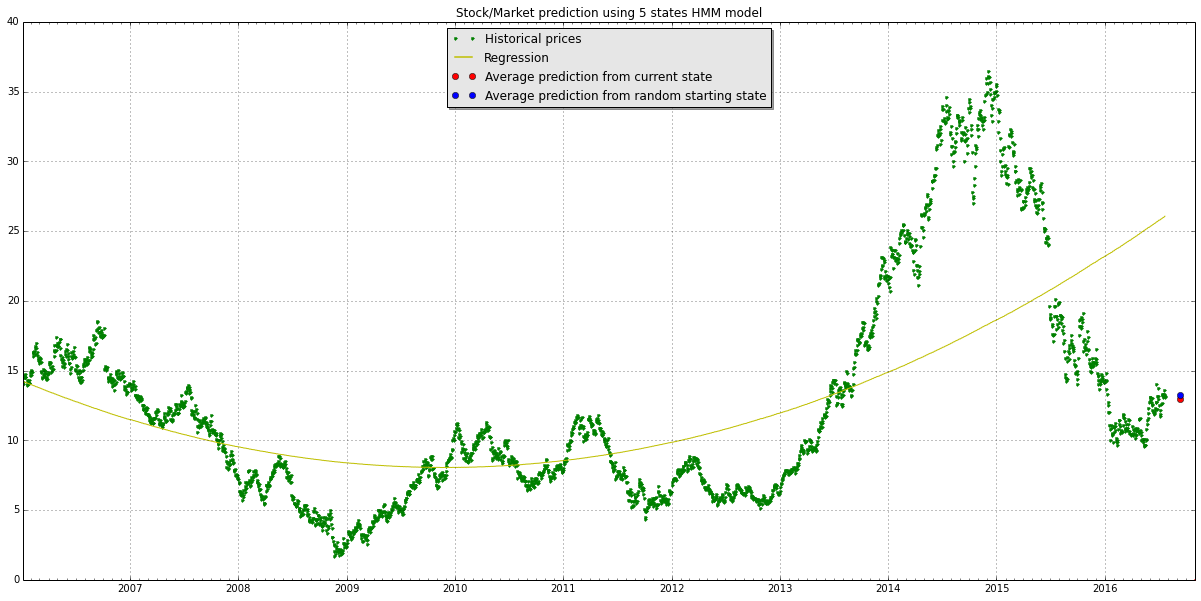

In [38]:
# Graph the historical prices, the regression, and the prediction averages from the HMM model

fig, ax = plt.subplots(figsize=(21,10))
ax.plot_date(dates,close_v,'.g', label='Historical prices')
plt.plot(dates,vvals,'-y', label='Regression')

#ax.xlabel('time')
#ax.ylabel('price')
ax.set_title('Stock/Market prediction using ' + str(num_of_states) + ' states HMM model')

plt.plot_date(dates[-1]+2*days*total2active,0,'.r') # just to expand the graph

plt.plot_date(dates[-1]+days*total2active,avg_prediction,'ro', label = 'Average prediction from current state')
plt.plot_date(dates[-1]+days*total2active,avg_prediction2,'bo', label = 'Average prediction from random starting state')

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.grid()

# Now add the legend with some customizations.
legend = ax.legend(loc='upper center', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

<b> Note: It is interesting that even one year later there is a marked difference in the predicted prices due to the starting state used.</b>

<b>Repeating but this time using only 3 hidden states:</b>

In [39]:

num_of_states = 2

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=num_of_states, covariance_type="full", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
hidden_probs = model.predict_proba(X)
print ("\nMost likely state of last observation:",hidden_states[-1])
print ("# of observations",hidden_states.size)
print ("Prob. distr. of states for last observation: \n",hidden_probs[-1])
print ("# of hidden states",model.n_components)

print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("hidden state # {0}".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()




Most likely state of last observation: 0
# of observations 50
Prob. distr. of states for last observation: 
 [  1.00000000e+000   2.11416560e-209]
# of hidden states 2
Transition matrix
[[ 0.97916667  0.02083333]
 [ 1.          0.        ]]

Means and vars of each hidden state
hidden state # 0
mean =  [ 0.00312044]
var =  [ 0.20100156]

hidden state # 1
mean =  [-3.02068947]
var =  [ 0.01]



In [40]:
# Generate samples starting in the actual current state

startprob = np.zeros(num_of_states)
startprob[hidden_states[-1]] = 1.0

model_2_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_2_sample.startprob_ = startprob
model_2_sample.transmat_ = model.transmat_
model_2_sample.means_ = model.means_
model_2_sample.covars_ = model.covars_


X, Z = model_2_sample.sample(days)
print ("")
print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction += final_price
    #time.sleep (.01)
    X, Z = model_2_sample.sample(days)


avg_prediction = avg_prediction/test_num
print ("Avg. Predicted Price:", avg_prediction)
print (" done")


Most recent closing price 13.13 Starting state:  0

Avg. Predicted Price: [ 10.22783357]
 done


In [41]:
# Generate samples starting in a random state 

startprob = np.zeros(num_of_states)
for start_st_prob in range(num_of_states):
    startprob[start_st_prob] = 1.0/num_of_states
print ('Starting probability for the different states: ',startprob)

model_3_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_3_sample.startprob_ = startprob
model_3_sample.transmat_ = model.transmat_
model_3_sample.means_ = model.means_
model_3_sample.covars_ = model.covars_


predictions2 = []
X2, Z2 = model_3_sample.sample(days)

print ("")
#print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction2 = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction2 += final_price
    #time.sleep (.01)
    X, Z = model_3_sample.sample(days)


avg_prediction2 = avg_prediction2/test_num
print ("Avg. Predicted Price:", avg_prediction2)
print (" done")

Starting probability for the different states:  [ 0.5  0.5]


Avg. Predicted Price: [ 8.93252093]
 done


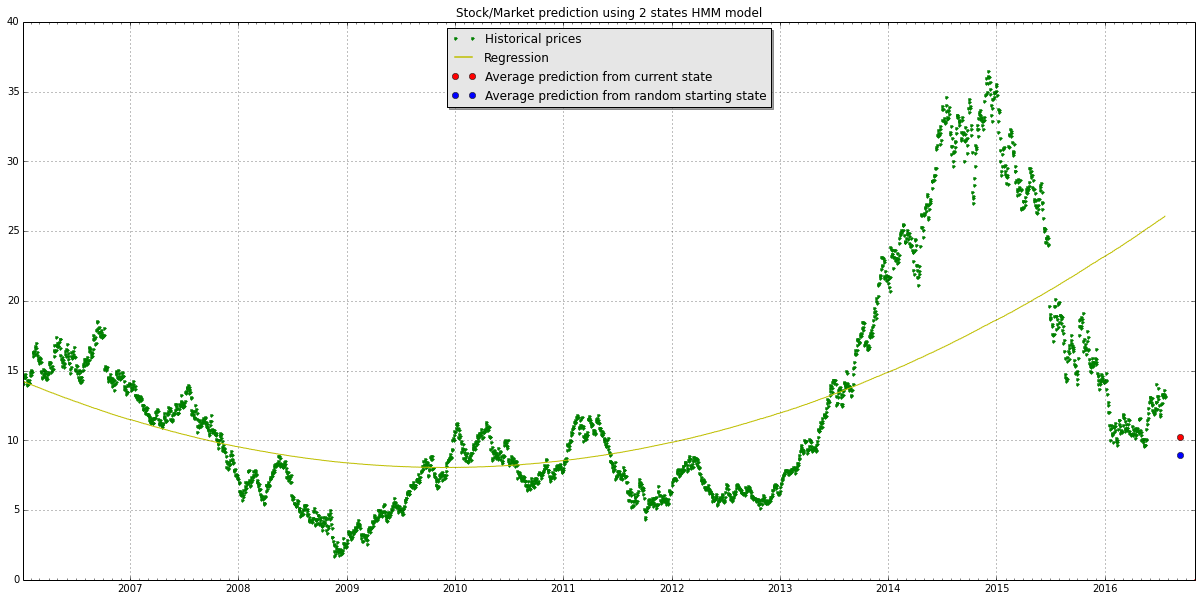

In [42]:
fig, ax = plt.subplots(figsize=(21,10))
ax.plot_date(dates,close_v,'.g', label='Historical prices')
plt.plot(dates,vvals,'-y', label='Regression')

#ax.xlabel('time')
#ax.ylabel('price')
ax.set_title('Stock/Market prediction using ' + str(num_of_states) + ' states HMM model')

plt.plot_date(dates[-1]+2*days*total2active,0,'.r') # just to expand the graph

plt.plot_date(dates[-1]+days*total2active,avg_prediction,'ro', label = 'Average prediction from current state')
plt.plot_date(dates[-1]+days*total2active,avg_prediction2,'bo', label = 'Average prediction from random starting state')

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.grid()

# Now add the legend with some customizations.
legend = ax.legend(loc='upper center', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

When having only two states there is only a very slight difference in the prediction depending on the starting state.

<b>Repeating but this time using only 9 hidden states:</b>

In [43]:
num_of_states = 9

# Make an HMM instance and execute fit
model = GaussianHMM(n_components=num_of_states, covariance_type="full", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
hidden_probs = model.predict_proba(X)
print ("\nMost likely state of last observation:",hidden_states[-1])
print ("# of observations",hidden_states.size)
print ("Prob. distr. of states for last observation: \n",hidden_probs[-1])
print ("# of hidden states",model.n_components)

print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("hidden state # {0}".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()



Most likely state of last observation: 6
# of observations 50
Prob. distr. of states for last observation: 
 [  3.59427665e-05   1.76749791e-03   0.00000000e+00   3.52557993e-01
   2.06893718e-01   5.52820661e-13   4.38475590e-01   2.69257999e-04
   2.61887702e-25]
# of hidden states 9
Transition matrix
[[  4.79355945e-004   7.70671062e-006   5.83199702e-112   4.95328511e-001
    1.79752201e-001   7.35504022e-016   3.24432226e-001   8.26723632e-033
    3.01413743e-060]
 [  2.05585407e-001   5.37429242e-013   6.69626877e-074   3.92344993e-006
    7.55757778e-002   3.02237229e-013   5.59305187e-001   1.52045902e-032
    1.59529705e-001]
 [  4.99888110e-001   1.64767397e-044   0.00000000e+000   5.88480908e-032
    5.00111890e-001   4.58080616e-077   1.42283117e-012   1.21196912e-060
    3.08882364e-203]
 [  6.44687196e-001   2.15413851e-007   1.11841366e-070   7.02854511e-017
    2.29925594e-014   8.69710344e-033   7.54388419e-002   1.86852991e-001
    9.30207555e-002]
 [  6.26208994e-01

In [44]:
# Generate samples starting in the actual current state

startprob = np.zeros(num_of_states)
startprob[hidden_states[-1]] = 1.0

model_2_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_2_sample.startprob_ = startprob
model_2_sample.transmat_ = model.transmat_
model_2_sample.means_ = model.means_
model_2_sample.covars_ = model.covars_


X, Z = model_2_sample.sample(days)
print ("")
print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction += final_price
    #time.sleep (.01)
    X, Z = model_2_sample.sample(days)


avg_prediction = avg_prediction/test_num
print ("Avg. Predicted Price:", avg_prediction)
print (" done")


Most recent closing price 13.13 Starting state:  6

Avg. Predicted Price: [ 10.63796624]
 done


In [45]:
# Generate samples starting in a random state 

startprob = np.zeros(num_of_states)
for start_st_prob in range(num_of_states):
    startprob[start_st_prob] = 1.0/num_of_states
print ('Starting probability for the different states: ',startprob)

model_3_sample = GaussianHMM(n_components=num_of_states, covariance_type="full")
model_3_sample.startprob_ = startprob
model_3_sample.transmat_ = model.transmat_
model_3_sample.means_ = model.means_
model_3_sample.covars_ = model.covars_


predictions2 = []
X2, Z2 = model_3_sample.sample(days)

print ("")
#print ("Most recent closing price",close_v[-1], 'Starting state: ',Z[0])
print ("")

avg_prediction2 = 0

for test in range(test_num):  
    final_price = close_v[-1]
    for i in range(days):
        if ((final_price+X[i]) > 0 ):
            final_price += X[i]
    
    #predictions.append(final_price)
    avg_prediction2 += final_price
    #time.sleep (.01)
    X, Z = model_3_sample.sample(days)


avg_prediction2 = avg_prediction2/test_num
print ("Avg. Predicted Price:", avg_prediction2)
print (" done")

Starting probability for the different states:  [ 0.11111111  0.11111111  0.11111111  0.11111111  0.11111111  0.11111111
  0.11111111  0.11111111  0.11111111]


Avg. Predicted Price: [ 9.83065975]
 done


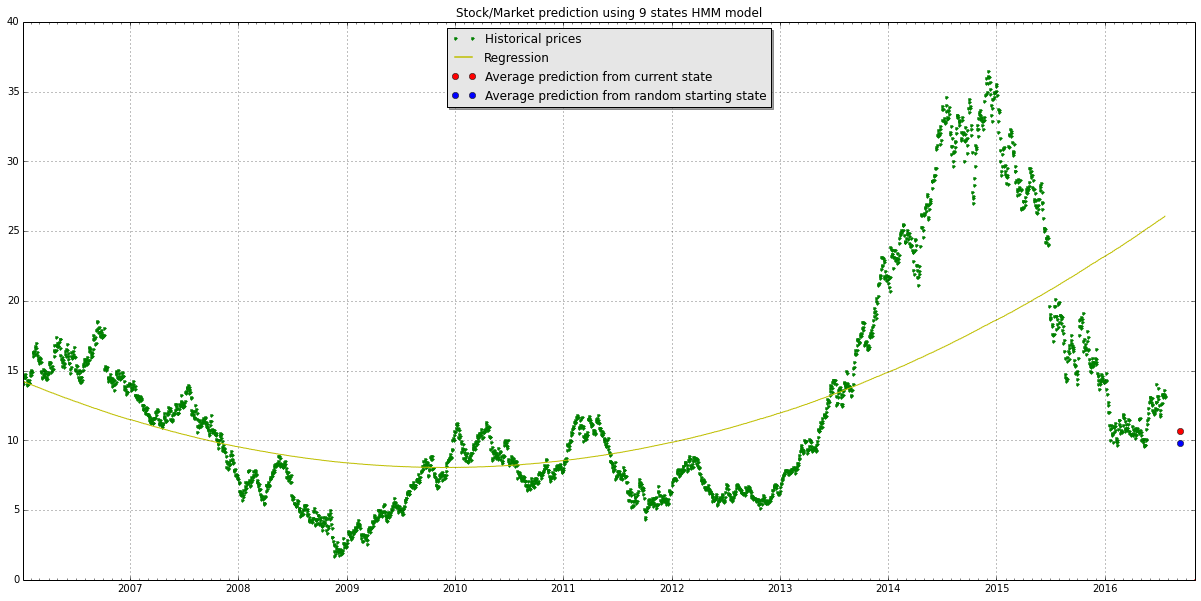

In [46]:
fig, ax = plt.subplots(figsize=(21,10))
ax.plot_date(dates,close_v,'.g', label='Historical prices')
plt.plot(dates,vvals,'-y', label='Regression')

#ax.xlabel('time')
#ax.ylabel('price')
ax.set_title('Stock/Market prediction using ' + str(num_of_states) + ' states HMM model')

plt.plot_date(dates[-1]+2*days*total2active,0,'.r') # just to expand the graph

plt.plot_date(dates[-1]+days*total2active,avg_prediction,'ro', label = 'Average prediction from current state')
plt.plot_date(dates[-1]+days*total2active,avg_prediction2,'bo', label = 'Average prediction from random starting state')

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_minor_locator(MonthLocator())
ax.grid()

# Now add the legend with some customizations.
legend = ax.legend(loc='upper center', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

When having nine states there is also only a very slight difference in the prediction depending on the starting state. Sometimes they even overlap !

<b>Conclusions so far:</b>
<ul>
  <li>The current inferred state continues to have a significant effect on the prediction average after one year.</li>
  <li>Using too many or too few hidden states degrades the quality of the predictions one year out, using five seems appropriate. </li>
  <li>More research needs to be done on whether the last state of the Viterbi inferred sequence should be used, or if instead the state with the highest posterior probability for the last observation should be employed. </li>
  <li>I am considering training a recurrent neural network to compare it to the HMM model.</li>
</ul>
